# Capstone Project

### Data Cleaning and EDA

In [44]:
#Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline

**Read in both #workfromhome and #remotework**

In [45]:
wfh_df = pd.read_csv("../dataset/tweet_df.csv")
rw_df = pd.read_csv("../dataset/remote_work.csv")

In [46]:
#https://catriscode.com/2021/03/02/extracting-or-removing-mentions-and-hashtags-in-tweets-using-python/
#https://www.debuggex.com/cheatsheet/regex/python
def remove_splchar(tweet):
    tweet = tweet.lower() # Lowercases the string
    tweet = re.sub('@[^\s]+', ' ', tweet) # remove usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet) #remove URLs
    tweet=re.sub('[^a-zA-Z#]', ' ', tweet) # remove special characters, numbers, punctuations
    tweet = re.sub("#[A-Za-z0-9_]+"," ", tweet) #remove hashtags
    tweet = re.sub(r"\s+", " ", str(tweet)) # replace double spaces with single space
    return tweet

In [47]:
#https://www.geeksforgeeks.org/python-spilt-a-sentence-into-list-of-words/
#https://stackoverflow.com/questions/771918/how-do-i-do-word-stemming-or-lemmatization
def lemmitize(tweet):
    clean_column_list = []
    wnl = WordNetLemmatizer()
    words = tweet.split()
    for word in words:
        clean_column_list.append(wnl.lemmatize(word)) 
    return " ".join(clean_column_list)

In [48]:
#Instantiate sentimnt analysis
sent = pipeline('sentiment-analysis')

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
#Get polarity score of each tweet
def getPolarity(tweet):
    polarity_dic = sent(tweet)
    if polarity_dic[0]['label'] == 'POSITIVE':
        return 1
    else:
        return 0

**#workfromhome  dataframe cleaning**

In [50]:
#Drop Unnamed: 0 column
wfh_df.drop('Unnamed: 0', axis=1, inplace=True)

In [51]:
#Check to confirm if the column got deleted 
wfh_df.head(3)

,tweets,user_location,tweet_posted_on,tweet_id
0,Quickly learn how to construct a really good c...,"London, England",Fri Jul 16 22:34:40 +0000 2021,1416164405633499136
1,Could YOU Fire Your Boss and Live the Dream? T...,"Chapala, Jalisco, Mexico",Fri Jul 16 22:28:19 +0000 2021,1416162808379678722
2,Are you exhausting yourself trying to make a s...,"Jalisco, México-retired Iowan",Fri Jul 16 22:21:11 +0000 2021,1416161014496874498


In [52]:
#Check the shape of the dataframe
wfh_df.shape

(5397, 4)

In [53]:
#Check missing values
wfh_df.isnull().sum()

tweets             0
user_location      0
tweet_posted_on    0
tweet_id           0
dtype: int64

In [54]:
#Check datatypes
wfh_df.dtypes

tweets             object
user_location      object
tweet_posted_on    object
tweet_id            int64
dtype: object

In [55]:
# Change column to be datetime dtype
#https://stackoverflow.com/questions/50503033/remove-minutes-and-hours-from-series
wfh_df['tweet_posted_on'] = pd.to_datetime(wfh_df['tweet_posted_on'])

In [56]:
wfh_df['user_location'].unique()

array(['London, England', 'Chapala, Jalisco, Mexico',
       'Jalisco, México-retired Iowan', ..., 'San Francisco, California ',
       'Knoxville, TN', 'no where'], dtype=object)

In [57]:
#https://stackoverflow.com/questions/52673285/performance-of-pandas-apply-vs-np-vectorize-to-create-new-column-from-existing-c/52674448#52674448
#Create a new column for processed tweets
wfh_df['cleaned_tweets'] = np.vectorize(remove_splchar)(wfh_df['tweets'])

In [58]:
#Get list of words which have more than 3 letters
wfh_df['cleaned_tweets'] = wfh_df['cleaned_tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [59]:
# Place new lists of lemmitized words into the 'cleaned_tweets' column in the dataframe
wfh_df['cleaned_tweets'] = wfh_df['cleaned_tweets'].map(lemmitize)

In [60]:
#Create a new column 'polarity' to save tweet polarity score
wfh_df['polarity'] = wfh_df['cleaned_tweets'].map(getPolarity)

In [61]:
#Change column order
wfh_df = wfh_df[['tweet_id','tweet_posted_on','tweets','cleaned_tweets','user_location','polarity']]

In [62]:
#Check the dataframe
wfh_df.head(3)

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,polarity
0,1416164405633499136,2021-07-16 22:34:40+00:00,Quickly learn how to construct a really good c...,quickly learn construct really good want recei...,"London, England",1
1,1416162808379678722,2021-07-16 22:28:19+00:00,Could YOU Fire Your Boss and Live the Dream? T...,could fire your bos live dream this waiter could,"Chapala, Jalisco, Mexico",1
2,1416161014496874498,2021-07-16 22:21:11+00:00,Are you exhausting yourself trying to make a s...,exhausting yourself trying make sale online wo...,"Jalisco, México-retired Iowan",0


**#remotework dataframe cleaning**

In [63]:
#Drop Unnamed: 0 column
rw_df.drop('Unnamed: 0', axis=1, inplace=True)

In [64]:
#Check to confirm if the column got deleted 
rw_df.head(3)

,tweets,user_location,tweet_posted_on,tweet_id
0,🏡 #RemoteWork is on the rise &amp; slowly beco...,"New York, NY",Fri Jul 16 23:43:03 +0000 2021,1416181616846811137
1,Opportunity to join a fantastic team at a hi-t...,London | New York,Fri Jul 16 23:42:07 +0000 2021,1416181380279635970
2,Good news for #JobSeekers open to #RemoteWork!...,Sydney | Hong Kong | Singapore,Fri Jul 16 23:41:30 +0000 2021,1416181225979473920


In [65]:
#Check the shape of the dataframe
rw_df.shape

(5429, 4)

In [66]:
#Check missing values
rw_df.isnull().sum()

tweets             0
user_location      0
tweet_posted_on    0
tweet_id           0
dtype: int64

In [67]:
#Check datatypes
rw_df.dtypes

tweets             object
user_location      object
tweet_posted_on    object
tweet_id            int64
dtype: object

In [68]:
# Change column to be datetime dtype
rw_df['tweet_posted_on'] = pd.to_datetime(rw_df['tweet_posted_on'])

In [69]:
rw_df['user_location'].unique()

array(['New York, NY', 'London | New York',
       'Sydney | Hong Kong | Singapore', ...,
       'At home. Dressed comfortably.', 'Long Beach NY & NYC',
       'Miami/LA '], dtype=object)

In [70]:
#Create a new column for processed tweets
rw_df['cleaned_tweets'] = np.vectorize(remove_splchar)(rw_df['tweets'])

In [71]:
#Get list of words which have more than 3 letters
rw_df['cleaned_tweets'] = rw_df['cleaned_tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [72]:
# Place new lists of lemmitized words into the 'cleaned_tweets' column in the dataframe
rw_df['cleaned_tweets'] = rw_df['cleaned_tweets'].map(lemmitize)

In [73]:
#Create a new column 'polarity' to save tweet polarity score
rw_df['polarity'] = rw_df['cleaned_tweets'].map(getPolarity)

In [74]:
#Change column order
rw_df = rw_df[['tweet_id','tweet_posted_on','tweets','cleaned_tweets','user_location','polarity']]

In [75]:
#Check the dataframe
rw_df.head(3)

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,polarity
0,1416181616846811137,2021-07-16 23:43:03+00:00,🏡 #RemoteWork is on the rise &amp; slowly beco...,rise slowly becoming normal which mean need re...,"New York, NY",1
1,1416181380279635970,2021-07-16 23:42:07+00:00,Opportunity to join a fantastic team at a hi-t...,opportunity join fantastic team tech fast pace...,London | New York,1
2,1416181225979473920,2021-07-16 23:41:30+00:00,Good news for #JobSeekers open to #RemoteWork!...,good news open this excellent report from remo...,Sydney | Hong Kong | Singapore,1


### Merge both dataframes

In [80]:
#https://www.geeksforgeeks.org/python-intersection-two-lists/
#Check number of rows that are common in both based on 'tweet_id'
len(set(rw_df['tweet_id']).intersection(wfh_df['tweet_id']))

592

In [82]:
#https://stackoverflow.com/questions/21317384/pandas-python-how-to-concatenate-two-dataframes-without-duplicates
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
#Concatenate both datasets
final_df = pd.concat([rw_df,wfh_df]).drop_duplicates(subset=['tweet_id'], keep='first').reset_index(drop=True)

In [83]:
#Check the shape of the dataframe
final_df.shape

(10234, 6)

In [88]:
final_df.head(3)

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,polarity
0,1416181616846811137,2021-07-16 23:43:03+00:00,🏡 #RemoteWork is on the rise &amp; slowly beco...,rise slowly becoming normal which mean need re...,"New York, NY",1
1,1416181380279635970,2021-07-16 23:42:07+00:00,Opportunity to join a fantastic team at a hi-t...,opportunity join fantastic team tech fast pace...,London | New York,1
2,1416181225979473920,2021-07-16 23:41:30+00:00,Good news for #JobSeekers open to #RemoteWork!...,good news open this excellent report from remo...,Sydney | Hong Kong | Singapore,1


In [97]:
#Save in a 'dataset' folder with a name 'final_df.csv'
final_df.to_csv('../dataset/final_df.csv')

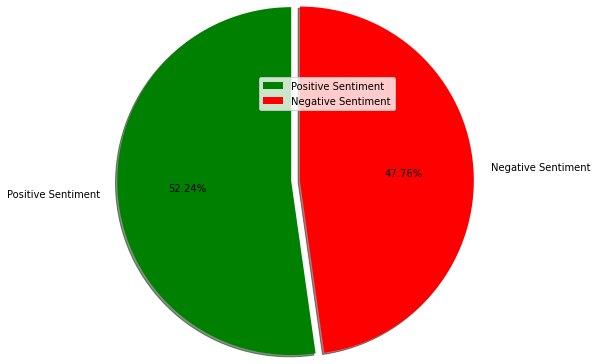

In [87]:
#https://stackoverflow.com/questions/39969089/how-to-create-pie-chart
#https://stackoverflow.com/questions/19852215/how-to-add-a-legend-to-matplotlib-pie-chart
sentiments = ['Positive Sentiment', 'Negative Sentiment'] 
data = [(final_df['polarity'] != 0).sum(), (final_df['polarity'] == 0).sum()] 
colors = ['g', 'r'] 
plt.pie(data,labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), autopct = '%1.2f%%',radius=2) 
plt.legend()
plt.show()

In [89]:
X = final_df['cleaned_tweets']
y = final_df['polarity']

In [90]:
cv_bigrams = CountVectorizer(stop_words = 'english',ngram_range=(2,2))
cv_bigrams.fit(final_df['cleaned_tweets'])
bigrams_cv = cv_bigrams.transform(final_df['cleaned_tweets'])
bigrams_df = pd.DataFrame(bigrams_cv.todense(),columns=cv_bigrams.get_feature_names())

In [91]:
# cv_X = cv.fit_transform(X)

In [92]:
# # Create cv_train dataframe
# cv_X_df = pd.DataFrame(cv_X.toarray(), columns = cv.get_feature_names())
# cv_X_df.head()

In [93]:
#commonwords
#cv_X_df.sum().sort_values(ascending=False).head(12)

In [96]:
bigrams_df.sum().sort_values(ascending=False).head(50).index

Index(['remote work', 'work home', 'working home', 'software engineer',
       'remote mailchimp', 'post pandemic', 'remote apply', 'hiring remotely',
       'hybrid work', 'home office', 'tweeted remote', 'work remotely',
       'remote incluzion', 'office chair', 'remote worker', 'remote working',
       'starting business', 'type time', 'basic basic', 'business basic',
       'design starting', 'uniquely design', 'chair worth', 'working remotely',
       'oblek office', 'look like', 'entered oblek',
       'competitive compensation', 'make money', 'featured opportunity',
       'apply share', 'share friend', 'hybrid model', 'hiring remote',
       'time hiring', 'read blog', 'social medium', 'role working',
       'work life', 'senior software', 'success working', 'key success',
       'ebooks key', 'finance post', 'working rebuild', 'rebuild finance',
       'critical ebooks', 'remote team', 'pandemic review',
       'exciting opportunity'],
      dtype='object')